# Compare Modtran/libRadTran Magnitudes

- author : Sylvie Dagoret
- affiliation : LAL/IN2P3/CNRS
- creation date : July 10th 2018



In [107]:
import pandas as pd
import numpy as np
import os,sys
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline
from scipy.interpolate import interp1d

In [108]:
from astropy.io import fits

In [109]:
from lsst.sims.photUtils import SignalToNoise
from lsst.sims.photUtils import PhotometricParameters
from lsst.sims.photUtils import Bandpass,Sed

In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [112]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [113]:
PATH_LIBRADTRAN='./librandtran'
PATH_MODTRAN='./modtran'
PATH_MYLSSTSIMS='./lsst_sims'

In [114]:
sys.path.append(PATH_LIBRADTRAN)
sys.path.append(PATH_MODTRAN)
sys.path.append(PATH_MYLSSTSIMS)

In [115]:
import libReadModtran as mt
import libsimulateTranspLSSTScattAbsAer3 as rt

In [116]:
from MyTelescope import *
from MyThroughputs import *

In [117]:
def plot_sedimg(data,index_spec):
    plt.figure(figsize=(15,10))   
    img=plt.imshow(data[1:,index_spec:],origin='lower',cmap='jet')
    plt.colorbar(img)
    plt.grid(True)
    plt.title('sed grid')
    plt.xlabel('bin number of wavelengths')
    plt.ylabel('sed number')
    plt.show()

In [118]:
def plot_allsed(data,index_spec):
    plt.figure()   
    
    for idx in np.arange(data.shape[0]-1):
      
        plt.semilogy(data[0,index_spec:],data[1+idx,index_spec:],'-')
    plt.grid(True)
    plt.title('sed')
    plt.xlabel('wavelength (A)')
    plt.ylabel('sed (flam)')
    plt.show()

# Config

In [119]:
#------------------------------------------------------------------------
# Definition of data format for the atmospheric grid
#-----------------------------------------------------------------------------
WLMIN=250.  # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=1151. # Minimum wavelength : PySynPhot works with Angstrom
WL=np.arange(WLMIN,WLMAX,1) # Array of wavelength in Angstrom
NBWL=len(WL)


In [120]:
## Config LSST

In [121]:
all_filternum = {'u':1, 'g':2, 'r':3, 'i':4, 'z':5, 'y':6}

In [122]:
LSST_SkyBrightness=np.array([22.03,21.68,21.02,19.7,17.83,17.21])

In [123]:
LSST_GeomSeeing=np.array([1.1,1.02,0.95,0.92,0.88,0.94])

# Configuration of input SED

In [124]:
sed_file="regenerated_sedgrid_pickle_uvk.fits"

In [125]:
sed_hdu = fits.open(sed_file)

In [126]:
theheader=sed_hdu[0].header
theheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 8515                                                  
NAXIS2  =                12963                                                  
NBSED   =                12962                                                  
NBWLBIN =                 8510                                                  
WLMIN   =               3000.0                                                  
WLMAX   =              11510.0                                                  
WLBINWDT=                  1.0                                                  
SEDUNIT = 'FLAM    '                                                            
SEDMODEL= 'pickle_uvk'                                                          
IDX_NUM =                   

In [127]:
sidx_num=theheader['IDX_NUM']
sidx_val=theheader['IDX_VAL']
sidx_sed=theheader['IDX_SED']
sidx_data=theheader['IDX_DATA']
sidx_spec=theheader['IDX_SPEC']

In [128]:
sed_data=sed_hdu[0].data

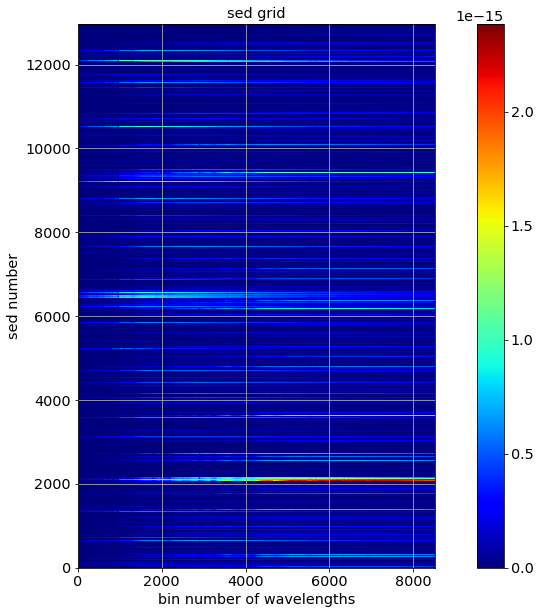

In [129]:
plot_sedimg(sed_data,sidx_spec)

In [ ]:
plot_allsed(sed_data,sidx_spec)

In [ ]:
NBSED_MAX=sed_data.shape[0]-1

In [ ]:
NBSED_MAX

## Config for Modtran

In [ ]:
path_modtrandata='modtrandata/Jul6th2018'

In [ ]:
def GetModtranFilenames():
    files_data = [f for f in listdir(path_modtrandata) if isfile(join(path_modtrandata, f))]
    files_data.sort()
    
    # select reduced files
    files_selected=[]
    for file in files_data:
        if file.find("_reduced")==-1:
            print("reject ",file)
        else:
            files_selected.append(file)
            
    files_selected.sort()
    return files_selected


In [ ]:
def GetAirmassFromModtranFilename(filename):
    splitted_filename=filename.split('.')
    tagname=splitted_filename[1]
    airmass_str=tagname.split('_')[0]
    am=float(airmass_str)/10.
    return am
    

In [ ]:
files_modtran=GetModtranFilenames()

In [ ]:
NBMTFILES=len(files_modtran)-1

### Get all all available Modtran Airmasss

In [ ]:
all_airmasses=[GetAirmassFromModtranFilename(files_modtran[idx]) for idx in np.arange(NBMTFILES) ]

### Read all Modtran Data

In [ ]:
all_mtdata=[]
for file in files_modtran:
    fullfilename=os.path.join(path_modtrandata,file)
    read_modtrandata=mt.loadtape7(fullfilename, colspec = ['WAVELENGTH_NM','COMBIN_TRANS'])
    all_mtdata.append(read_modtrandata)

### View all Modtran Data

In [ ]:
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=NBMTFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

In [ ]:
for idx in np.arange(NBMTFILES):    
    colorVal = scalarMap.to_rgba(idx)
    thelabel="z={:2.1f}".format(all_airmasses[idx])
    plt.plot(all_mtdata[idx][:,0],all_mtdata[idx][:,1],color=colorVal,label=thelabel)
plt.grid(True)
plt.title("MODTRAN 07/06/2018")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("atmospheric transparency")
plt.legend(loc='best')

In [ ]:
all_airmasses

# Select One Airmass and One Filter where to do the Comparison

In [ ]:
idx_am_sel=0

In [ ]:
am=all_airmasses[idx_am_sel]

In [ ]:
mtdata_sel=all_mtdata[idx_am_sel]

Must extend Motran transmission up from 250 nm to 1151 nm

In [ ]:
wl0=mtdata_sel[:,0]
tr0=mtdata_sel[:,1]

In [ ]:
wl=np.copy(WL)
tr=np.ones(NBWL)

wl[:len(wl0)]=wl0[:]
tr[:len(tr0)]=tr0[:]


In [ ]:
tel_mt=Telescope()

In [ ]:
tel_mt.Set_Atmosphere(am,wl,tr)
tel_mt.Plot_Throughputs()

## Tune pwv

In [ ]:
all_pwv=np.arange(0.,10.,1)

In [ ]:
NBRTFILES=len(all_pwv)

In [ ]:
NBSED_SEL=5000

# Simulate LibRadTran

In [ ]:

pressure = 782.5
pwv=4.0
aer=0
ozone=300.
wl0=500.

In [ ]:
all_rtdata=[]
for pwv in all_pwv:
    path,thefile=rt.ProcessSimulationaer(am,pwv,ozone,wl0,aer)
    #path,thefile=rt.ProcessSimulation(am,pwv,ozone)
    data = np.loadtxt(os.path.join(path,thefile))
    all_rtdata.append(data)

In [ ]:
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=NBRTFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

In [ ]:
for idx in np.arange(NBRTFILES):    
    colorVal = scalarMap.to_rgba(idx)
    thelabel="pwv={:2.1f}".format(all_pwv[idx])
    plt.plot(all_rtdata[idx][:,0],all_rtdata[idx][:,1],color=colorVal,label=thelabel)
plt.grid(True)
plt.title("LIBRADTRAN for z={:2.1f}".format(am))
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("atmospheric transparency")
plt.legend(loc='upper left')

# LibRadTran Telescope

In [ ]:
idx_pwv_sel=5

In [ ]:
rtdata_sel=all_rtdata[idx_pwv_sel]

In [ ]:
tel_rt=Telescope()

In [ ]:
tel_rt.Set_Atmosphere(am,rtdata_sel[:,0],rtdata_sel[:,1])
tel_rt.Plot_Throughputs()

# LOOP on SED

In [ ]:

filter_tag='y'


In [ ]:
def ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data):
    
    
    filternum=all_filternum[filter_tag]-1
    skybrightness=LSST_SkyBrightness[filternum]
    FWHMgeom=LSST_GeomSeeing[filternum]
    
    
    # book collections
    all_pulls=np.zeros(NBSED_SEL)
    all_magdelta=np.zeros(NBSED_SEL)
    all_magerr=np.zeros(NBSED_SEL)

    #print("NBSED_SEL={}".format(NBSED_SEL))
    
    #loop on SED
    for idx_sed in np.arange(NBSED_SEL):
        # extract sed wl and flux
        picklesname='pickles_uvk_{}'.format(idx_sed+1)
        wl_sed=sed_data[0,sidx_spec:]/10.
        flux_sed=sed_data[idx_sed+1,sidx_spec:]*10.
        
        # fill Telescope with that SED
        tel_rt.Set_SED(wavel=wl_sed,newsed=flux_sed,name=picklesname)
        tel_mt.Set_SED(wavel=wl_sed,newsed=flux_sed,name=picklesname)
        
        #compute Instrumental Magnitude
        mag_adu_mt=tel_mt.CalcMyADUMagnitude_filter(filter_tag)
        mag_adu_rt=tel_rt.CalcMyADUMagnitude_filter(filter_tag)
        
        # compute magnitude error and delta mag
        mag_error=tel_rt.CalcMyABMagnitudesError_filter(filter_tag,skybrightness,FWHMgeom)
        delta_mag= mag_adu_mt-mag_adu_rt
    
        #print('\Delta M = {} \delta m = {} '.format(delta_mag,mag_error))
        
        #fill collection
        all_pulls[idx_sed]=delta_mag/mag_error
        all_magdelta[idx_sed]=delta_mag
        all_magerr[idx_sed]=mag_error
        
        
        #plt.semilogy(wl_sed,flux_sed)

    return all_magdelta,all_magerr,all_pulls
        

In [ ]:
def ComputeChi2(all_pulls):
    all_pulls2=all_pulls**2
    N=len(all_pulls)
    chi2=all_pulls2.sum()/(float(N-1))
    return chi2

In [ ]:
all_magdelta,all_magerr,all_pulls=ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data)

In [ ]:
ComputeChi2(all_pulls)

In [ ]:
plt.hist(all_pulls,bins=50,range=(-0.02,0.02));
plt.grid()
plt.xlabel("pull")

In [ ]:
plt.hist(all_magdelta,bins=50,range=(-0.001,0.001));
plt.grid()
plt.xlabel("$\Delta M$")

In [ ]:
plt.hist(all_magerr,bins=50);
plt.grid()
plt.xlabel("$\delta M$")
plt.yscale('log')

# LOOP ON PWV

In [ ]:
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=NBRTFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

In [ ]:
all_chi2=[]

plt.figure()
for idx,pwv in np.ndenumerate(all_pwv):
    print("index_pwv={} , pwv={}".format(idx[0],pwv))
    
    
    # select atmosphere for libradtran
    idx_pwv_sel=idx[0]
    rtdata_sel=all_rtdata[idx_pwv_sel]
    tel_rt.Set_Atmosphere(am,rtdata_sel[:,0],rtdata_sel[:,1])
    all_magdelta,all_magerr,all_pulls=ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data)
    all_chi2.append(ComputeChi2(all_pulls))
    
    colorVal = scalarMap.to_rgba(idx_pwv_sel)
    thelabel="pwv={:2.1f} mm".format(idx_pwv_sel)
    
    plt.hist(all_pulls,bins=100,range=(-0.2,0.2),color=colorVal,alpha=0.8);
plt.grid(True)
plt.xlabel("pull",fontweight='bold',fontsize=20)
title="Pulls Distribution pull$\equiv(M_{mt}^Y-M_{rt}^Y)/\sigma_M$"
title=title+" for airmass z={}".format(am)
plt.title(title,fontweight='bold',fontsize=25)
#plt.legend(loc='best')

# Estimation of PWV in libradtran

In [ ]:
x=np.array(all_pwv)
y=np.array(all_chi2)
z = np.polyfit(x, y, 4)
parab= np.poly1d(z)
newx=np.linspace(x[0],x[-1],50)
newy=parab(newx)

In [ ]:
title="$\chi^2/(N-1)$ vs pwv for $\Delta M^Y=M_{mt}^Y-M_{rt}^Y$"
title=title+" for airmass z={}".format(am)
plt.plot(all_pwv,all_chi2,'bo',label='data')
plt.plot(newx,newy,'r:',label='fit')
plt.ylabel("$\chi^2/(N-1)$",fontweight='bold',fontsize=20)
plt.xlabel("pwv in mm",fontweight='bold',fontsize=20)
plt.grid(True)
plt.title(title,fontweight='bold',fontsize=25)
plt.legend(loc="upper right")

In [ ]:
z

In [ ]:
def FindOptimum(X,Y):
    idx0=np.where(Y==Y.min())[0][0]
    print("minimum is at X={}, Y={}".format(X[idx0],Y[idx0]))
    
    close_idx=np.where(Y<=Y.min()+1)[0]
    #for idx2 in close_idx:
    #      print("neighbourg {} : is at X={}, Y={}".format(idx2,X[idx2],Y[idx2]))
            
    print("X1 = {} - X2 = {}".format(X[close_idx[0]], X[close_idx[-1]]))
    sigma=0.5*( (X[idx0]-X[close_idx[0]])+(X[close_idx[-1]]-X[idx0]))
    print("Sigma= {}".format(sigma))
    return X[idx0],sigma

In [ ]:
pwv0,sigpwv=FindOptimum(newx,newy)

In [ ]:
pwv0

# Find Magnitude difference

In [ ]:
path,thefile=rt.ProcessSimulationaer(am,pwv0,ozone,wl0,aer)
#path,thefile=rt.ProcessSimulation(am,pwv,ozone)
rtdata0 = np.loadtxt(os.path.join(path,thefile))

In [ ]:
tel_rt.Set_Atmosphere(am,rtdata0[:,0],rtdata0[:,1])

In [ ]:
all_magdelta0,all_magerr0,all_pulls0=ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data)

In [ ]:
plt.hist(all_pulls0,bins=50,range=(-0.02,0.02));
plt.grid()
plt.xlabel("pull")